<a href="https://colab.research.google.com/github/samanthajmichael/complaints/blob/main/notebooks/Sentiment_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class FinBERTSentimentRegressor(nn.Module):
    def __init__(self, model_name="ProsusAI/finbert", freeze_layers=9):
        super(FinBERTSentimentRegressor, self).__init__()

        # Load pre-trained FinBERT model
        self.bert = AutoModel.from_pretrained(model_name)

        # Freeze the specified number of layers
        modules = [self.bert.embeddings, *self.bert.encoder.layer[:freeze_layers]]
        for module in modules:
            for param in module.parameters():
                param.requires_grad = False

        # Get the hidden size from the model config
        hidden_size = self.bert.config.hidden_size

        # Create regression head with fully connected layers
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Tanh()  # Output between -1 and 1
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        token_embeddings = outputs.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        token_embeddings[input_mask_expanded == 0] = -1e9
        pooled_output = torch.max(token_embeddings, dim=1)[0]
        sentiment_score = self.regressor(pooled_output)
        return sentiment_score


In [7]:
# Custom dataset for financial text with sentiment scores
class FinancialSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)
        }


In [8]:
# Training function with early stopping
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs=5, patience=3):
    # Loss function for regression
    criterion = nn.MSELoss()

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_mae': []
    }

    # Early stopping variables
    best_val_loss = float('inf')
    best_model_state = None
    counter = 0
    early_stop = False

    for epoch in range(epochs):
        if early_stop:
            print(f"Early stopping triggered after epoch {epoch}")
            break

        print(f"Epoch {epoch+1}/{epochs}")

        # Training phase
        model.train()
        train_loss = 0
        train_steps = 0

        for batch in tqdm(train_loader, desc="Training"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.squeeze(), labels)

            # Backward pass and optimization
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            train_steps += 1

        avg_train_loss = train_loss / train_steps
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        val_mae = 0
        val_steps = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.squeeze(), labels)

                # Calculate Mean Absolute Error
                mae = torch.mean(torch.abs(outputs.squeeze() - labels))

                val_loss += loss.item()
                val_mae += mae.item()
                val_steps += 1

        avg_val_loss = val_loss / val_steps
        avg_val_mae = val_mae / val_steps

        history['val_loss'].append(avg_val_loss)
        history['val_mae'].append(avg_val_mae)

        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Val MAE: {avg_val_mae:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            print(f"Validation loss decreased from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            counter = 0
        else:
            counter += 1
            print(f"Validation loss did not improve. Counter: {counter}/{patience}")
            if counter >= patience:
                print("Early stopping triggered!")
                early_stop = True

        print("-" * 50)

    # Load the best model state if we did early stopping
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation loss: {best_val_loss:.4f}")

    return history


In [9]:
def load_checkpoint(checkpoint_path, model, optimizer=None, scheduler=None):
    """
    Load a checkpoint and restore model, optimizer and scheduler states.

    Args:
        checkpoint_path (str): Path to the checkpoint file
        model: Model to restore
        optimizer: Optional optimizer to restore
        scheduler: Optional scheduler to restore

    Returns:
        checkpoint (dict): Loaded checkpoint dictionary
        starting_epoch (int): Epoch to resume from
        global_step (int): Global step to resume from
    """
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)

    # Load model state
    model.load_state_dict(checkpoint['/content/model_state_dict'])

    # Optionally load optimizer state
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['/content/optimizer_state_dict'])

    # Optionally load scheduler state
    if scheduler is not None and 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['/content/scheduler_state_dict'])

    # Get starting epoch and global step
    starting_epoch = checkpoint.get('epoch', 0)
    global_step = checkpoint.get('global_step', 0)

    print(f"Checkpoint loaded. Resuming from epoch {starting_epoch}, global step {global_step}")
    return checkpoint, starting_epoch, global_step

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Number of trainable parameters: 22092289
Epoch 1/15


Validation: 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]


Train Loss: 0.1641
Val Loss: 0.1360
Val MAE: 0.3280
Validation loss decreased from inf to 0.1360. Saving model...
--------------------------------------------------
Epoch 2/15


Validation: 100%|██████████| 8/8 [00:01<00:00,  4.67it/s]


Train Loss: 0.1494
Val Loss: 0.1119
Val MAE: 0.2898
Validation loss decreased from 0.1360 to 0.1119. Saving model...
--------------------------------------------------
Epoch 3/15


Validation: 100%|██████████| 8/8 [00:01<00:00,  4.76it/s]


Train Loss: 0.1176
Val Loss: 0.0811
Val MAE: 0.2217
Validation loss decreased from 0.1119 to 0.0811. Saving model...
--------------------------------------------------
Epoch 4/15


Validation: 100%|██████████| 8/8 [00:01<00:00,  4.76it/s]


Train Loss: 0.0968
Val Loss: 0.0764
Val MAE: 0.1979
Validation loss decreased from 0.0811 to 0.0764. Saving model...
--------------------------------------------------
Epoch 5/15


Validation: 100%|██████████| 8/8 [00:01<00:00,  4.64it/s]


Train Loss: 0.0841
Val Loss: 0.0745
Val MAE: 0.1934
Validation loss decreased from 0.0764 to 0.0745. Saving model...
--------------------------------------------------
Epoch 6/15


Validation: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]


Train Loss: 0.0728
Val Loss: 0.0806
Val MAE: 0.1988
Validation loss did not improve. Counter: 1/3
--------------------------------------------------
Epoch 7/15


Validation: 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


Train Loss: 0.0660
Val Loss: 0.0804
Val MAE: 0.1967
Validation loss did not improve. Counter: 2/3
--------------------------------------------------
Epoch 8/15


Validation: 100%|██████████| 8/8 [00:01<00:00,  4.63it/s]


Train Loss: 0.0607
Val Loss: 0.0793
Val MAE: 0.1976
Validation loss did not improve. Counter: 3/3
Early stopping triggered!
--------------------------------------------------
Early stopping triggered after epoch 8
Loaded best model with validation loss: 0.0745
Training complete!

Evaluating on test set:


Testing: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


Test Loss (MSE): 0.0764
Test MAE: 0.1917
Pearson Correlation: 0.7494

Detailed Metrics:
Mean Squared Error (MSE): 0.0769
Root Mean Squared Error (RMSE): 0.2772
Mean Absolute Error (MAE): 0.1925
R² Score: 0.5404
Pearson Correlation: 0.7494


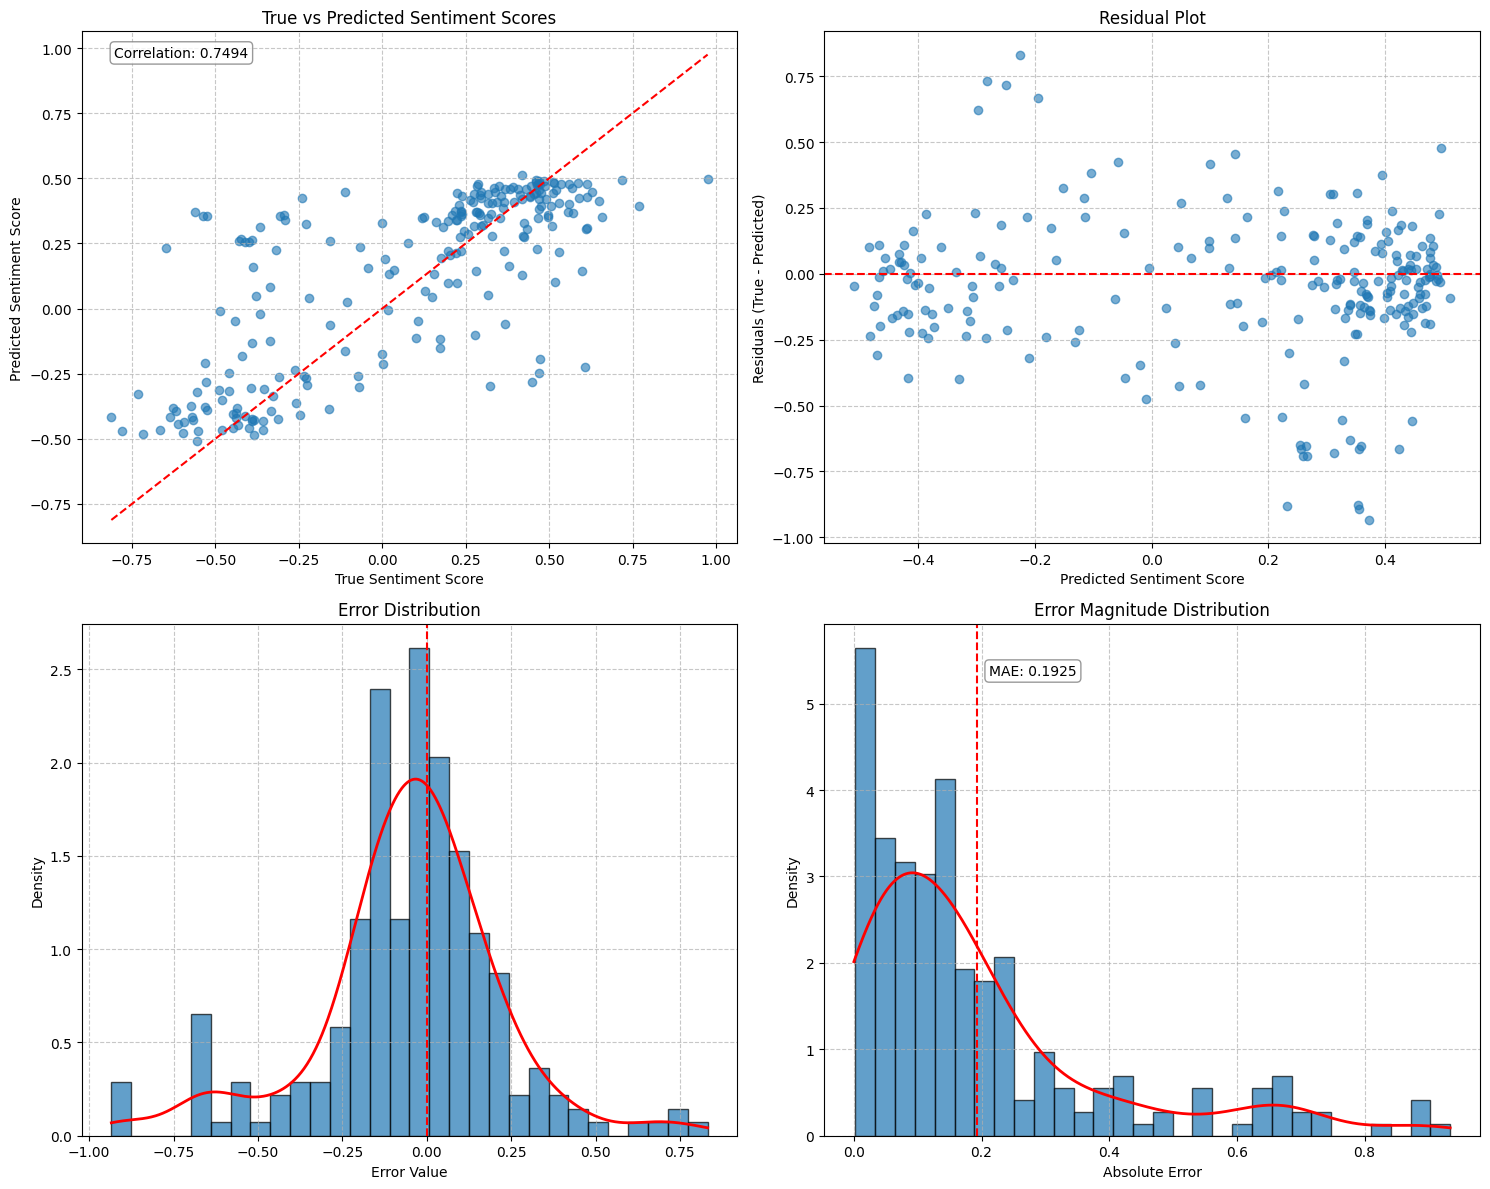


Examples with largest prediction errors:
Example 1:
Text: Timberrrr $TSLA https://t.co/MRBgfDHHVa...
True Score: -0.5620, Predicted: 0.3722, Error: -0.9342
----------------------------------------------------------------------
Example 2:
Text: loading $SPY and $AAPL puts. think were toppy IMHO....
True Score: -0.5370, Predicted: 0.3546, Error: -0.8916
----------------------------------------------------------------------
Example 3:
Text: Nine banks including Barclays, Citi, agree to pay $2 billion to settle forex ......
True Score: -0.6470, Predicted: 0.2324, Error: -0.8794
----------------------------------------------------------------------
Example 4:
Text: Locked in some $FB puts for nice gain...
True Score: -0.5240, Predicted: 0.3542, Error: -0.8782
----------------------------------------------------------------------
Example 5:
Text: Long $TSLA short $MBLY https://t.co/jSpUSzo6na...
True Score: 0.6070, Predicted: -0.2250, Error: 0.8320
------------------------------------------

<ipython-input-18-41e9dc608e25>:297: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(bin_labels, rotation=45)
<ipython-input-18-41e9dc608e25>:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(bin_labels, rotation=45)


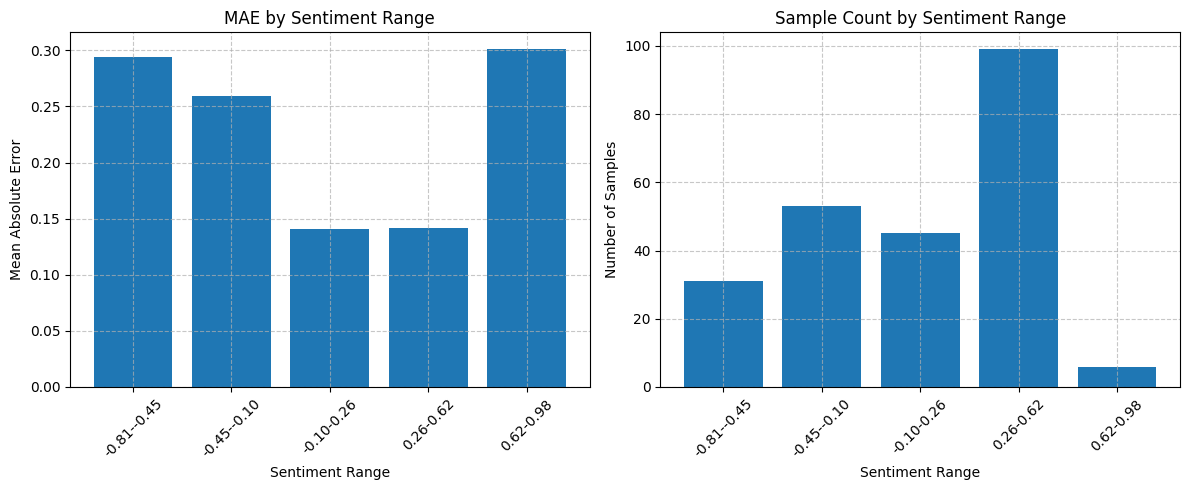


Sample predictions:
Text: Britain's FTSE steadies, supported by Dixons Carphone...
True Score: 0.3290, Predicted Score: 0.4033
--------------------------------------------------
Text: Glaxo's ViiV Healthcare Signs China Manufacturing Deal With Desano...
True Score: 0.2840, Predicted Score: 0.3691
--------------------------------------------------
Text: AstraZeneca sells Caprelsa rights to Sanofi unit...
True Score: 0.2330, Predicted Score: 0.2749
--------------------------------------------------
Text: UPDATE 5-Barclays Chairman McFarlane axes CEO to speed up strategic change...
True Score: -0.2290, Predicted Score: 0.3257
--------------------------------------------------
Text: Miners Meltdown as BHP to Rio Tinto Sink in Commodities Rout...
True Score: -0.6650, Predicted Score: -0.4664
--------------------------------------------------


In [18]:
# Function to prepare data and perform training
def main():
    # Load data from CSV files
    train_df = pd.read_csv('train.csv')
    valid_df = pd.read_csv('valid.csv')
    test_df = pd.read_csv('test.csv')

    # Assuming your CSV files have 'sentence' and 'score' columns
    # Adjust column names appropriately
    train_texts = train_df['sentence'].values
    train_scores = train_df['score'].values

    val_texts = valid_df['sentence'].values
    val_scores = valid_df['score'].values

    test_texts = test_df['sentence'].values
    test_scores = test_df['score'].values

    # Ensure scores are within [-1, 1] range
    # You may need to normalize your scores if they're not already in this range
    train_scores = np.clip(train_scores, -1, 1)
    val_scores = np.clip(val_scores, -1, 1)
    test_scores = np.clip(test_scores, -1, 1)

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

    # Create datasets
    train_dataset = FinancialSentimentDataset(train_texts, train_scores, tokenizer)
    val_dataset = FinancialSentimentDataset(val_texts, val_scores, tokenizer)

    # Create data loaders
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FinBERTSentimentRegressor(freeze_layers=9).to(device)

    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {trainable_params}")

    # Setup optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

    # Calculate total steps
    epochs = 10
    total_steps = len(train_loader) * epochs

    # Create learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=total_steps // 10,
        num_training_steps=total_steps
    )

    # Train the model with early stopping
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        epochs=epochs,
        patience=3  # Stop if no improvement for 3 consecutive epochs
    )

    # Save the model
    torch.save(model.state_dict(), "/content/finbert_sentiment_regressor.pt")

    print("Training complete!")

    # Evaluate on test set
    print("\nEvaluating on test set:")
    model.eval()
    test_dataset = FinancialSentimentDataset(test_texts, test_scores, tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    criterion = nn.MSELoss()
    test_loss = 0
    test_mae = 0
    test_steps = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.squeeze(), labels)
            mae = torch.mean(torch.abs(outputs.squeeze() - labels))

            test_loss += loss.item()
            test_mae += mae.item()
            test_steps += 1

            # Store predictions and labels for correlation calculation
            all_preds.extend(outputs.squeeze().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / test_steps
    avg_test_mae = test_mae / test_steps
    correlation = np.corrcoef(all_preds, all_labels)[0, 1]

    print(f"Test Loss (MSE): {avg_test_loss:.4f}")
    print(f"Test MAE: {avg_test_mae:.4f}")
    print(f"Pearson Correlation: {correlation:.4f}")

    # ADD THIS LINE HERE: Call the visualization function
    visualize_results(all_preds, all_labels, test_texts)

    # Function for making predictions on new text
    def predict_sentiment(text):
        model.eval()
        encoded_text = tokenizer(
            text,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoded_text['input_ids'].to(device)
        attention_mask = encoded_text['attention_mask'].to(device)

        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            score = output.item()

        return score

    # Example predictions on a few test samples
    print("\nSample predictions:")
    for i in range(min(5, len(test_texts))):
        true_score = test_scores[i]
        pred_score = predict_sentiment(test_texts[i])
        print(f"Text: {test_texts[i][:100]}...")
        print(f"True Score: {true_score:.4f}, Predicted Score: {pred_score:.4f}")
        print("-" * 50)

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def visualize_results(all_preds, all_labels, test_texts=None):
    """
    Visualize the performance of the FinBERT sentiment regression model using Matplotlib.

    Parameters:
    - all_preds: List of model predictions
    - all_labels: List of true labels
    - test_texts: Optional list of test texts for example visualization
    """

    # Convert to numpy arrays if they aren't already
    preds = np.array(all_preds)
    labels = np.array(all_labels)

    # Calculate metrics
    mse = mean_squared_error(labels, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels, preds)
    r2 = r2_score(labels, preds)
    correlation = np.corrcoef(preds, labels)[0, 1]

    # Print metrics
    print(f"\nDetailed Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Pearson Correlation: {correlation:.4f}")

    # Create figure and subplots
    fig = plt.figure(figsize=(15, 12))

    # 1. Actual vs Predicted Scatter Plot
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.scatter(labels, preds, alpha=0.6)

    # Add perfect prediction line
    min_val = min(min(labels), min(preds))
    max_val = max(max(labels), max(preds))
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--')

    ax1.set_title('True vs Predicted Sentiment Scores')
    ax1.set_xlabel('True Sentiment Score')
    ax1.set_ylabel('Predicted Sentiment Score')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Add correlation coefficient to the plot
    ax1.text(0.05, 0.95, f'Correlation: {correlation:.4f}',
             transform=ax1.transAxes,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    # 2. Residual Plot
    errors = labels - preds
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.scatter(preds, errors, alpha=0.6)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_title('Residual Plot')
    ax2.set_xlabel('Predicted Sentiment Score')
    ax2.set_ylabel('Residuals (True - Predicted)')
    ax2.grid(True, linestyle='--', alpha=0.7)

    # 3. Error Distribution (Histogram of residuals)
    ax3 = fig.add_subplot(2, 2, 3)
    n, bins, patches = ax3.hist(errors, bins=30, alpha=0.7, density=True, edgecolor='black')

    # Add a kernel density estimate
    kde_x = np.linspace(min(errors), max(errors), 1000)
    kde = gaussian_kde(errors)
    ax3.plot(kde_x, kde(kde_x), 'r-', linewidth=2)

    ax3.axvline(x=0, color='r', linestyle='--')
    ax3.set_title('Error Distribution')
    ax3.set_xlabel('Error Value')
    ax3.set_ylabel('Density')
    ax3.grid(True, linestyle='--', alpha=0.7)

    # 4. Error Magnitude Distribution
    abs_errors = np.abs(errors)
    ax4 = fig.add_subplot(2, 2, 4)
    n, bins, patches = ax4.hist(abs_errors, bins=30, alpha=0.7, density=True, edgecolor='black')

    # Add a kernel density estimate for absolute errors
    kde_x = np.linspace(0, max(abs_errors), 1000)
    abs_errors_kde = gaussian_kde(abs_errors)
    ax4.plot(kde_x, abs_errors_kde(kde_x), 'r-', linewidth=2)

    ax4.axvline(x=mae, color='r', linestyle='--')
    ax4.text(mae*1.1, ax4.get_ylim()[1]*0.9, f'MAE: {mae:.4f}',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    ax4.set_title('Error Magnitude Distribution')
    ax4.set_xlabel('Absolute Error')
    ax4.set_ylabel('Density')
    ax4.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('finbert_regression_results.png', dpi=300)
    plt.show()

    # 5. Bonus: Plot examples with largest errors if test_texts are provided
    if test_texts is not None and len(test_texts) == len(all_preds):
        # Get indices of 5 examples with largest absolute error
        worst_indices = np.argsort(abs_errors)[-5:][::-1]

        print("\nExamples with largest prediction errors:")
        for i, idx in enumerate(worst_indices):
            print(f"Example {i+1}:")
            print(f"Text: {test_texts[idx][:100]}...")
            print(f"True Score: {labels[idx]:.4f}, Predicted: {preds[idx]:.4f}, Error: {errors[idx]:.4f}")
            print("-" * 70)

    # 6. Additional analysis: Regression performance by sentiment range
    if len(labels) > 20:  # Only if we have enough data points
        plt.figure(figsize=(12, 5))

        # Create bins for sentiment ranges
        min_sentiment = min(labels)
        max_sentiment = max(labels)
        bins = np.linspace(min_sentiment, max_sentiment, 6)  # 5 ranges
        bin_labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)]

        # Assign each sample to a bin
        digitized = np.digitize(labels, bins) - 1
        digitized[digitized >= len(bin_labels)] = len(bin_labels) - 1  # Handle edge case

        # Calculate MAE per bin
        bin_maes = []
        bin_counts = []
        for i in range(len(bin_labels)):
            bin_mask = (digitized == i)
            if np.sum(bin_mask) > 0:
                bin_mae = mean_absolute_error(labels[bin_mask], preds[bin_mask])
                bin_maes.append(bin_mae)
                bin_counts.append(np.sum(bin_mask))
            else:
                bin_maes.append(0)
                bin_counts.append(0)

        # Plot MAE by sentiment range
        ax1 = plt.subplot(1, 2, 1)
        ax1.bar(bin_labels, bin_maes)
        ax1.set_title('MAE by Sentiment Range')
        ax1.set_xlabel('Sentiment Range')
        ax1.set_ylabel('Mean Absolute Error')
        ax1.set_xticklabels(bin_labels, rotation=45)
        ax1.grid(True, linestyle='--', alpha=0.7)

        # Plot sample count by sentiment range
        ax2 = plt.subplot(1, 2, 2)
        ax2.bar(bin_labels, bin_counts)
        ax2.set_title('Sample Count by Sentiment Range')
        ax2.set_xlabel('Sentiment Range')
        ax2.set_ylabel('Number of Samples')
        ax2.set_xticklabels(bin_labels, rotation=45)
        ax2.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.savefig('finbert_performance_by_range.png', dpi=300)
        plt.show()

if __name__ == "__main__":
    main()

### Sentiment Inference

In [23]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm  # Use notebook version of tqdm

# Define the model architecture (same as in your training script)
class FinBERTSentimentRegressor(torch.nn.Module):
    def __init__(self, model_name="prosusai/finbert"):
        super(FinBERTSentimentRegressor, self).__init__()

        # Load pre-trained FinBERT model
        self.bert = AutoModel.from_pretrained(model_name)

        # Get the hidden size from the model config
        hidden_size = self.bert.config.hidden_size

        # Create regression head with fully connected layers
        self.regressor = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(64, 1),
            torch.nn.Tanh()  # Output between -1 and 1
        )

    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Use max pooling instead of CLS token
        token_embeddings = outputs.last_hidden_state

        # Create an expanded mask for proper masking before max pooling
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

        # Set padding tokens to large negative value so they don't affect max pooling
        token_embeddings[input_mask_expanded == 0] = -1e9

        # Apply max pooling over the token dimension
        pooled_output = torch.max(token_embeddings, dim=1)[0]

        # Pass through the regressor to get sentiment score
        sentiment_score = self.regressor(pooled_output)

        return sentiment_score

# Dataset for inference
class InferenceDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'text': text
        }

# Load the model
def load_model(model_path, device):
    """
    Load the trained model from a saved file
    """
    # Initialize model
    model = FinBERTSentimentRegressor().to(device)

    # Load the model weights
    try:
        # First try to load as a simple state dict (the preferred method)
        model.load_state_dict(torch.load(model_path, map_location=device))
        print("Loaded model state directly")
    except:
        # If that fails, try loading as a checkpoint dictionary
        checkpoint = torch.load(model_path, map_location=device)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print("Loaded model state from checkpoint dictionary")
        else:
            raise ValueError(f"Could not load model from {model_path}. Incompatible format.")

    model.eval()  # Set model to evaluation mode
    return model

# Run inference
def predict_sentiment_scores(model, data_loader, device):
    """
    Run inference on the data loader and return predictions
    """
    model.eval()
    all_predictions = []
    all_texts = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Scoring"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            texts = batch['text']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = outputs.squeeze().cpu().numpy()

            # Handle single item batches
            if isinstance(predictions, np.float32):
                predictions = [predictions]
            else:
                predictions = predictions.tolist()

            all_predictions.extend(predictions)
            all_texts.extend(texts)

    return all_predictions, all_texts

# Score a CSV file with text data
def score_csv_file(model_path, input_file, text_column='text', output_file=None, batch_size=16, max_len=512):
    """
    Score texts from a CSV file and save results
    """
    # Determine device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load the model
    model = load_model(model_path, device)
    print(f"Model loaded from {model_path}")

    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

    # Load the data
    df = pd.read_csv(input_file)
    if text_column not in df.columns:
        raise ValueError(f"Text column '{text_column}' not found in {input_file}")

    texts = df[text_column].values
    print(f"Loaded {len(texts)} texts from {input_file}")

    # Create dataset and dataloader
    dataset = InferenceDataset(texts, tokenizer, max_len=max_len)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # Run prediction
    predictions, _ = predict_sentiment_scores(model, dataloader, device)

    # Add predictions to dataframe
    df['sentiment_score'] = predictions

    # Save results if output file is specified
    if output_file:
        df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")

    # Print a few examples
    print("\nSample predictions:")
    for i in range(min(5, len(predictions))):
        print(f"Text: {texts[i][:100]}...")
        print(f"Sentiment Score: {predictions[i]:.4f}")
        print("-" * 50)

    return df

# Score a list of texts
def score_texts(model_path, texts, batch_size=16, max_len=512):
    """
    Score a list of texts using the trained model

    Args:
        model_path (str): Path to the trained model file
        texts (list): List of texts to score
        batch_size (int): Batch size for inference
        max_len (int): Maximum sequence length

    Returns:
        list: List of sentiment scores for each text
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load the model
    model = load_model(model_path, device)
    print(f"Model loaded from {model_path}")

    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

    # Create dataset and dataloader
    dataset = InferenceDataset(texts, tokenizer, max_len=max_len)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # Run prediction
    predictions, _ = predict_sentiment_scores(model, dataloader, device)

    return predictions

In [30]:
df = pd.read_csv('/content/complaints.csv')
df = df.loc[(df['Product']=='Bank account or service') | (df['Product']=='Checking or savings account') | (df['Product']=='Money transfers') | (df['Product']=='Money transfer, virtual currency, or money service')]
df = df.rename(columns={
    'Date received': 'Date',
    'Consumer complaint narrative': 'Complaint'
})
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
df = df[['Date', 'Product', 'Complaint']]
df = df.dropna(subset=['Complaint'])
df.info()
print(df.head())
print(df.columns)
df.to_csv('/content/cleaned_complaints.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 20347 entries, 3 to 138918
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       20347 non-null  datetime64[ns]
 1   Product    20347 non-null  object        
 2   Complaint  20347 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 635.8+ KB
         Date                                            Product  \
3  2022-10-26  Money transfer, virtual currency, or money ser...   
7  2023-02-10                        Checking or savings account   
11 2024-10-31                        Checking or savings account   
12 2023-02-02                        Checking or savings account   
18 2023-03-01                        Checking or savings account   

                                            Complaint  
3   On XX/XX/2022, I was contacted by XXXX XXXX ; ...  
7   I had been banking with Wells Fargo since XXXX...  
11  From XXXX until XXX

In [31]:
# Score texts in a CSV file
scored_df = score_csv_file(
    model_path='/content/finbert_sentiment_regressor.pt',  # Update with model path
    input_file='/content/cleaned_complaints.csv',  # Update with input file path
    text_column='Complaint',  # Update with text column name
    output_file='/content/scored_results.csv',  # where to save results
    batch_size=16
)


Using device: cuda
Loaded model state directly
Model loaded from /content/finbert_sentiment_regressor.pt
Loaded 20347 texts from /content/cleaned_complaints.csv


Scoring:   0%|          | 0/1272 [00:00<?, ?it/s]

Results saved to /content/scored_results.csv

Sample predictions:
Text: On XX/XX/2022, I was contacted by XXXX XXXX ; phone number ; ( XXXX ) XXXX through messenger. He pre...
Sentiment Score: -0.1377
--------------------------------------------------
Text: I had been banking with Wells Fargo since XXXX. I not to long ago closed my account due to problems ...
Sentiment Score: -0.3922
--------------------------------------------------
Text: From XXXX until XXXXXXXX XXXX XXXX someone had access to our accounts. We have already had an open c...
Sentiment Score: -0.2935
--------------------------------------------------
Text: Several years ago opened an additional savings account with Wells Fargo because they stated that if ...
Sentiment Score: -0.0685
--------------------------------------------------
Text: I stopped using my wells Fargo account because Im XXXX they started to take out money even though I ...
Sentiment Score: -0.3605
--------------------------------------------------


'\n# EXAMPLE 2: Score a list of texts directly\nexample_texts = [\n    "I am very satisfied with the bank\'s handling of my account. They were responsive and resolved my issue quickly.",\n    "The bank repeatedly charged me hidden fees without proper notification. This has been going on for months.",\n    "Despite multiple attempts to resolve my issue, the company has not responded to any of my inquiries."\n]\n\nscores = score_texts(\n    model_path=\'/content/finbert_sentiment_regressor.pt\',  # Update with your model path\n    texts=example_texts,\n    batch_size=16\n)\n\n# Display results\nfor text, score in zip(example_texts, scores):\n    sentiment = "Positive" if score > 0.3 else "Negative" if score < -0.3 else "Neutral"\n    print(f"Text: {text[:100]}...")\n    print(f"Score: {score:.4f} ({sentiment})")\n    print("-" * 50)\n'

In [ ]:
## Uncomment out for different usage methods
# # Score a list of texts directly
# example_texts = [
#     "I am very satisfied with the bank's handling of my account. They were responsive and resolved my issue quickly.",
#     "The bank repeatedly charged me hidden fees without proper notification. This has been going on for months.",
#     "Despite multiple attempts to resolve my issue, the company has not responded to any of my inquiries."
# ]

# scores = score_texts(
#     model_path='/content/finbert_sentiment_regressor.pt',  # Update with model path
#     texts=example_texts,
#     batch_size=16
# )

# # Display results
# for text, score in zip(example_texts, scores):
#     sentiment = "Least Severe" if score > 0.75 else "Most Severe" if score < -0.75 else "Neutral"
#     print(f"Text: {text[:100]}...")
#     print(f"Score: {score:.4f} ({sentiment})")
#     print("-" * 50)

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_sentiment_distribution(scored_df, sentiment_column='sentiment_score'):
    """
    Create a histogram of sentiment scores.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Get sentiment scores
    scores = scored_df[sentiment_column]

    # Create histogram
    n, bins, patches = ax.hist(scores, bins=30, alpha=0.7, color='skyblue', edgecolor='black')

    # Add vertical lines for reference
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
    ax.axvline(x=-0.75, color='red', linestyle='--', alpha=0.5, label='Severe threshold (-0.75)')
    ax.axvline(x=0.75, color='green', linestyle='--', alpha=0.5, label='Least Severe threshold (0.75)')

    # Add labels and title
    ax.set_title('Distribution of Sentiment Scores', fontsize=16)
    ax.set_xlabel('Sentiment Score', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

def create_sentiment_categories(scored_df, sentiment_column='sentiment_score', thresholds=(-0.75, 0.75)):
    """
    Add a sentiment category column based on score thresholds.
    """
    df = scored_df.copy()

    # Create sentiment categories
    df['sentiment_category'] = 'Neutral'
    df.loc[df[sentiment_column] < thresholds[0], 'sentiment_category'] = 'Most Severe'
    df.loc[df[sentiment_column] > thresholds[1], 'sentiment_category'] = 'Least Severe'

    return df

def count_categories(categorized_df, category_column='sentiment_category'):
    """
    Count occurrences of each category.
    """
    categories = categorized_df[category_column].unique()
    counts = {}

    for category in categories:
        counts[category] = sum(categorized_df[category_column] == category)

    return counts

def plot_sentiment_barchart(categorized_df, category_column='sentiment_category'):
    """
    Create a bar chart of sentiment categories using matplotlib.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Count categories
    counts = count_categories(categorized_df, category_column)

    # Order categories if all three are present
    ordered_categories = []
    for cat in ['Most Severe', 'Neutral', 'Least Severe']:
        if cat in counts:
            ordered_categories.append(cat)

    # Get counts in order
    ordered_counts = [counts[cat] for cat in ordered_categories]

    # Define colors for categories
    colors = {'Least Severe': 'green', 'Neutral': 'gray', 'Most Severe': 'red'}
    category_colors = [colors.get(cat, 'blue') for cat in ordered_categories]

    # Create bar chart
    bars = ax.bar(
        ordered_categories,
        ordered_counts,
        color=category_colors,
        alpha=0.7,
        edgecolor='black'
    )

    # Add count labels on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.1,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontweight='bold'
        )

    ax.set_title('Count of Documents by Sentiment Category', fontsize=16)
    ax.set_xlabel('Sentiment Category', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    return fig

def plot_score_ranges(categorized_df, sentiment_column='sentiment_score', bins=10):
    """
    Create a histogram with colored regions for different sentiment ranges.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Get sentiment scores
    scores = categorized_df[sentiment_column]

    # Create histogram
    n, bins, patches = ax.hist(scores, bins=bins, alpha=0.7, edgecolor='black')

    # Color the bars based on sentiment ranges
    for i, patch in enumerate(patches):
        if bins[i] < -0.75:
            patch.set_facecolor('red')
        elif bins[i] >= 0.75:
            patch.set_facecolor('green')
        else:
            patch.set_facecolor('gray')

    # Add vertical lines for thresholds
    ax.axvline(x=-0.75, color='red', linestyle='--', alpha=0.7, label='Severe threshold')
    ax.axvline(x=0.75, color='green', linestyle='--', alpha=0.7, label='Least Severe threshold')

    # Add labels and title
    ax.set_title('Sentiment Score Distribution with Category Ranges', fontsize=16)
    ax.set_xlabel('Sentiment Score', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

def plot_text_length_vs_sentiment(categorized_df, text_column, sentiment_column='sentiment_score'):
    """
    Plot text length against sentiment score.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Calculate text lengths
    text_lengths = []
    sentiment_scores = []

    for _, row in categorized_df.iterrows():
        text = str(row[text_column])
        text_lengths.append(len(text))
        sentiment_scores.append(row[sentiment_column])

    # Create scatter plot with colormap
    sc = ax.scatter(
        text_lengths,
        sentiment_scores,
        alpha=0.5,
        c=sentiment_scores,  # Color by sentiment
        cmap='RdYlGn',  # Red for negative, green for least severe
        edgecolor='black'
    )

    # Add a colorbar
    cbar = plt.colorbar(sc)
    cbar.set_label('Sentiment Score', rotation=270, labelpad=20)

    # Add horizontal lines for reference
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    ax.axhline(y=-0.75, color='red', linestyle='--', alpha=0.5)
    ax.axhline(y=0.75, color='green', linestyle='--', alpha=0.5)

    # Add labels and title
    ax.set_title('Relationship Between Text Length and Sentiment Score', fontsize=16)
    ax.set_xlabel('Text Length (characters)', fontsize=12)
    ax.set_ylabel('Sentiment Score', fontsize=12)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

def plot_monthly_sentiment(df, date_column, sentiment_column='sentiment_score'):
    """
    Plot average sentiment aggregated by month with improved x-axis labeling.
    """
    # Convert to datetime if not already
    df_copy = df.copy()
    if not pd.api.types.is_datetime64_dtype(df_copy[date_column]):
        df_copy[date_column] = pd.to_datetime(df_copy[date_column], errors='coerce')

    # Create month column
    df_copy['year_month'] = df_copy[date_column].dt.strftime('%Y-%m')

    # Group by month and calculate average sentiment
    monthly_data = df_copy.groupby('year_month').agg({
        sentiment_column: 'mean',
        date_column: 'count'
    }).reset_index()

    # Rename columns for clarity
    monthly_data.columns = ['year_month', 'avg_sentiment', 'count']

    # Ensure chronological order
    monthly_data['sort_date'] = pd.to_datetime(monthly_data['year_month'] + '-01')
    monthly_data = monthly_data.sort_values('sort_date')

    # Create month labels (e.g., Jan 2023)
    monthly_data['month_label'] = monthly_data['sort_date'].dt.strftime('%b %Y')

    # Create figure
    fig, ax = plt.subplots(figsize=(14, 6))

    # Get x-axis positions
    x_positions = range(len(monthly_data))

    # Create the bar chart
    bars = ax.bar(
        x_positions,
        monthly_data['avg_sentiment'],
        alpha=0.7,
        width=0.7,
        edgecolor='black'
    )

    # Color the bars based on sentiment
    for i, bar in enumerate(bars):
        sentiment = monthly_data['avg_sentiment'].iloc[i]
        if sentiment < -0.75:
            bar.set_color('red')
        elif sentiment > 0.75:
            bar.set_color('green')
        else:
            bar.set_color('gray')

    # Add zero line
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # Determine appropriate tick spacing based on number of months
    num_months = len(monthly_data)

    # Set default tick spacing and method
    tick_spacing = 1

    if num_months > 12 and num_months <= 24:
        tick_spacing = 2  # Every other month
    elif num_months > 24 and num_months <= 60:
        tick_spacing = 3  # Quarterly
    elif num_months > 60:
        tick_spacing = 6  # Every half year

    # Create tick positions with appropriate spacing
    tick_positions = list(range(0, len(monthly_data), tick_spacing))
    tick_labels = [monthly_data['month_label'].iloc[i] for i in tick_positions]

    # Set x-axis ticks and labels
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')

    # Add count as text on each bar
    if num_months <= 30:  # Only show count for <= 30 months to avoid cluttering
        for i, (sentiment, count) in enumerate(zip(monthly_data['avg_sentiment'], monthly_data['count'])):
            y_pos = sentiment + 0.02 if sentiment >= 0 else sentiment - 0.02
            va = 'bottom' if sentiment >= 0 else 'top'

            ax.text(
                i, y_pos,
                f'n={count}',
                ha='center',
                va=va,
                fontsize=9,
                color='black'
            )

    # Add labels and title
    ax.set_title('Average Monthly Sentiment', fontsize=16)
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Average Sentiment Score', fontsize=12)
    ax.grid(axis='y', alpha=0.3)

    # Add threshold lines
    ax.axhline(y=0.75, color='green', linestyle='--', alpha=0.5, label='Least Severe threshold')
    ax.axhline(y=-0.75, color='red', linestyle='--', alpha=0.5, label='Most Severe threshold')
    ax.legend()

    # Ensure labels are visible
    plt.tight_layout()
    return fig

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_sentiment_distribution(scored_df, sentiment_column='sentiment_score'):
    """
    Create a histogram of sentiment scores.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Get sentiment scores
    scores = scored_df[sentiment_column]

    # Create histogram
    n, bins, patches = ax.hist(scores, bins=30, alpha=0.7, color='skyblue', edgecolor='black')

    # Add vertical lines for reference
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
    ax.axvline(x=-0.3, color='red', linestyle='--', alpha=0.5, label='Negative threshold (-0.3)')
    ax.axvline(x=0.3, color='green', linestyle='--', alpha=0.5, label='Positive threshold (0.3)')

    # Add labels and title
    ax.set_title('Distribution of Sentiment Scores', fontsize=16)
    ax.set_xlabel('Sentiment Score', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

def create_sentiment_categories(scored_df, sentiment_column='sentiment_score', thresholds=(-0.3, 0.3)):
    """
    Add a sentiment category column based on score thresholds.
    """
    df = scored_df.copy()

    # Create sentiment categories
    df['sentiment_category'] = 'Neutral'
    df.loc[df[sentiment_column] < thresholds[0], 'sentiment_category'] = 'Negative'
    df.loc[df[sentiment_column] > thresholds[1], 'sentiment_category'] = 'Positive'

    return df

def count_categories(categorized_df, category_column='sentiment_category'):
    """
    Count occurrences of each category.
    """
    categories = categorized_df[category_column].unique()
    counts = {}

    for category in categories:
        counts[category] = sum(categorized_df[category_column] == category)

    return counts

def plot_sentiment_pie(categorized_df, category_column='sentiment_category'):
    """
    Create a pie chart of sentiment categories using only matplotlib.
    """
    fig, ax = plt.subplots(figsize=(10, 7))

    # Count categories
    counts = count_categories(categorized_df, category_column)

    # Define colors for categories
    colors = {'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}

    # Get labels and values in consistent order
    labels = []
    sizes = []
    category_colors = []

    for category in counts:
        labels.append(category)
        sizes.append(counts[category])
        category_colors.append(colors.get(category, 'blue'))

    # Create explode values for emphasis
    explode = [0.05] * len(labels)

    # Create pie chart
    ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=category_colors,
        explode=explode,
        shadow=True,
        textprops={'fontsize': 12}
    )

    ax.set_title('Sentiment Distribution by Category', fontsize=16)
    ax.axis('equal')  # Equal aspect ratio ensures pie is circular

    plt.tight_layout()
    return fig

def plot_sentiment_barchart(categorized_df, category_column='sentiment_category'):
    """
    Create a bar chart of sentiment categories using matplotlib.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Count categories
    counts = count_categories(categorized_df, category_column)

    # Order categories if all three are present
    ordered_categories = []
    for cat in ['Negative', 'Neutral', 'Positive']:
        if cat in counts:
            ordered_categories.append(cat)

    # Get counts in order
    ordered_counts = [counts[cat] for cat in ordered_categories]

    # Define colors for categories
    colors = {'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}
    category_colors = [colors.get(cat, 'blue') for cat in ordered_categories]

    # Create bar chart
    bars = ax.bar(
        ordered_categories,
        ordered_counts,
        color=category_colors,
        alpha=0.7,
        edgecolor='black'
    )

    # Add count labels on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.1,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontweight='bold'
        )

    ax.set_title('Count of Documents by Sentiment Category', fontsize=16)
    ax.set_xlabel('Sentiment Category', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    return fig

def plot_score_ranges(categorized_df, sentiment_column='sentiment_score', bins=10):
    """
    Create a histogram with colored regions for different severity ranges.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Get sentiment scores
    scores = categorized_df[sentiment_column]

    # Create histogram
    n, bins, patches = ax.hist(scores, bins=bins, alpha=0.7, edgecolor='black')

    # Color the bars based on severity ranges
    for i, patch in enumerate(patches):
        if bins[i] < -0.75:
            patch.set_facecolor('darkred')  # Most Severe
        elif bins[i] < 0:
            patch.set_facecolor('indianred')  # Moderately Severe
        elif bins[i] >= 0.75:
            patch.set_facecolor('darkgreen')  # Least Severe
        elif bins[i] > 0:
            patch.set_facecolor('mediumseagreen')  # Moderately Low Severity
        else:
            patch.set_facecolor('gray')  # Neutral

    # Add vertical lines for thresholds
    ax.axvline(x=-0.75, color='red', linestyle='--', alpha=0.7, label='Most Severe threshold')
    ax.axvline(x=0.75, color='green', linestyle='--', alpha=0.7, label='Least Severe threshold')

    # Set x-axis limits to show full -1 to 1 range
    ax.set_xlim(-1.05, 1.05)

    # Add labels and title
    ax.set_title('Severity Score Distribution with Category Ranges', fontsize=16)
    ax.set_xlabel('Severity Score', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

def plot_text_length_vs_sentiment(categorized_df, text_column, sentiment_column='sentiment_score'):
    """
    Plot text length against severity score.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Calculate text lengths
    text_lengths = []
    sentiment_scores = []

    for _, row in categorized_df.iterrows():
        text = str(row[text_column])
        text_lengths.append(len(text))
        sentiment_scores.append(row[sentiment_column])

    # Create scatter plot with colormap
    sc = ax.scatter(
        text_lengths,
        sentiment_scores,
        alpha=0.5,
        c=sentiment_scores,  # Color by sentiment
        cmap='RdYlGn',  # Red for negative, green for positive
        edgecolor='black'
    )

    # Add a colorbar
    cbar = plt.colorbar(sc)
    cbar.set_label('Severity Score', rotation=270, labelpad=20)

    # Set y-axis limits to show full -1 to 1 range
    ax.set_ylim(-1.05, 1.05)

    # Add horizontal lines for reference
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    ax.axhline(y=-0.75, color='red', linestyle='--', alpha=0.5, label='Most Severe (-0.75)')
    ax.axhline(y=0.75, color='green', linestyle='--', alpha=0.5, label='Least Severe (0.75)')

    # Add labels and title
    ax.set_title('Relationship Between Text Length and Severity Score', fontsize=16)
    ax.set_xlabel('Text Length (characters)', fontsize=12)
    ax.set_ylabel('Severity Score', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

def plot_monthly_sentiment(df, date_column, sentiment_column='sentiment_score'):
    """
    Plot average sentiment aggregated by month with improved x-axis labeling.
    Shows full sentiment range from -1 to 1 with severity thresholds at ±0.75.
    """
    # Convert to datetime if not already
    df_copy = df.copy()
    if not pd.api.types.is_datetime64_dtype(df_copy[date_column]):
        df_copy[date_column] = pd.to_datetime(df_copy[date_column], errors='coerce')

    # Create month column
    df_copy['year_month'] = df_copy[date_column].dt.strftime('%Y-%m')

    # Group by month and calculate average sentiment
    monthly_data = df_copy.groupby('year_month').agg({
        sentiment_column: 'mean',
        date_column: 'count'
    }).reset_index()

    # Rename columns for clarity
    monthly_data.columns = ['year_month', 'avg_sentiment', 'count']

    # Ensure chronological order
    monthly_data['sort_date'] = pd.to_datetime(monthly_data['year_month'] + '-01')
    monthly_data = monthly_data.sort_values('sort_date')

    # Create month labels (e.g., Jan 2023)
    monthly_data['month_label'] = monthly_data['sort_date'].dt.strftime('%b %Y')

    # Create figure
    fig, ax = plt.subplots(figsize=(14, 6))

    # Get x-axis positions
    x_positions = range(len(monthly_data))

    # Create the bar chart
    bars = ax.bar(
        x_positions,
        monthly_data['avg_sentiment'],
        alpha=0.7,
        width=0.7,
        edgecolor='black'
    )

    # Color the bars based on sentiment severity
    for i, bar in enumerate(bars):
        sentiment = monthly_data['avg_sentiment'].iloc[i]
        if sentiment < -0.75:
            bar.set_color('darkred')  # Most Severe
        elif sentiment < 0:
            bar.set_color('indianred')  # Moderately Severe
        elif sentiment > 0.75:
            bar.set_color('darkgreen')  # Least Severe
        elif sentiment > 0:
            bar.set_color('mediumseagreen')  # Moderately Low Severity
        else:
            bar.set_color('gray')  # Neutral

    # Add zero line
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # Set y-axis limits to show full -1 to 1 range
    ax.set_ylim(-1.05, 1.05)  # Small buffer beyond -1,1 for readability

    # Determine appropriate tick spacing based on number of months
    num_months = len(monthly_data)

    # Set default tick spacing and method
    tick_spacing = 1

    if num_months > 12 and num_months <= 24:
        tick_spacing = 2  # Every other month
    elif num_months > 24 and num_months <= 60:
        tick_spacing = 3  # Quarterly
    elif num_months > 60:
        tick_spacing = 6  # Every half year

    # Create tick positions with appropriate spacing
    tick_positions = list(range(0, len(monthly_data), tick_spacing))
    tick_labels = [monthly_data['month_label'].iloc[i] for i in tick_positions]

    # Set x-axis ticks and labels
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')

    # Add count as text on each bar
    if num_months <= 30:  # Only show count for <= 30 months to avoid cluttering
        for i, (sentiment, count) in enumerate(zip(monthly_data['avg_sentiment'], monthly_data['count'])):
            y_pos = sentiment + 0.02 if sentiment >= 0 else sentiment - 0.02
            va = 'bottom' if sentiment >= 0 else 'top'

            ax.text(
                i, y_pos,
                f'n={count}',
                ha='center',
                va=va,
                fontsize=9,
                color='black'
            )

    # Add labels and title
    ax.set_title('Average Monthly Severity Score', fontsize=16)
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Average Severity Score (-1 to 1)', fontsize=12)
    ax.grid(axis='y', alpha=0.3)

    # Add threshold lines
    ax.axhline(y=0.75, color='green', linestyle='--', alpha=0.5, label='Least Severe threshold (0.75)')
    ax.axhline(y=-0.75, color='red', linestyle='--', alpha=0.5, label='Most Severe threshold (-0.75)')
    ax.legend()

    # Ensure labels are visible
    plt.tight_layout()
    return fig

def create_sentiment_categories(scored_df, sentiment_column='sentiment_score', thresholds=(-0.75, 0.75)):
    """
    Add a severity category column based on score thresholds.
    """
    df = scored_df.copy()

    # Create sentiment categories
    df['severity_category'] = 'Moderate'
    df.loc[df[sentiment_column] < thresholds[0], 'severity_category'] = 'Most Severe'
    df.loc[df[sentiment_column] > thresholds[1], 'severity_category'] = 'Least Severe'

    return df

def plot_sentiment_barchart(categorized_df, category_column='severity_category'):
    """
    Create a bar chart of severity categories using matplotlib.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Count categories
    counts = {}
    for category in categorized_df[category_column].unique():
        counts[category] = sum(categorized_df[category_column] == category)

    # Order categories
    ordered_categories = []
    for cat in ['Most Severe', 'Moderate', 'Least Severe']:
        if cat in counts:
            ordered_categories.append(cat)

    ordered_counts = [counts[cat] for cat in ordered_categories]

    # Define colors for categories
    colors = {'Least Severe': 'green', 'Moderate': 'gray', 'Most Severe': 'red'}
    category_colors = [colors.get(cat, 'blue') for cat in ordered_categories]

    # Create bar chart
    bars = ax.bar(
        ordered_categories,
        ordered_counts,
        color=category_colors,
        alpha=0.7,
        edgecolor='black'
    )

    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.1,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontweight='bold'
        )

    ax.set_title('Count of Documents by Severity Category', fontsize=16)
    ax.set_xlabel('Severity Category', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    return fig

def plot_sentiment_distribution(scored_df, sentiment_column='sentiment_score'):
    """
    Create a histogram of severity scores.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Get sentiment scores
    scores = scored_df[sentiment_column]

    # Create histogram
    n, bins, patches = ax.hist(scores, bins=30, alpha=0.7, color='skyblue', edgecolor='black')

    # Add vertical lines for reference
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
    ax.axvline(x=-0.75, color='red', linestyle='--', alpha=0.5, label='Most Severe threshold (-0.75)')
    ax.axvline(x=0.75, color='green', linestyle='--', alpha=0.5, label='Least Severe threshold (0.75)')

    # Set y-axis limits to show full -1 to 1 range
    ax.set_xlim(-1.05, 1.05)  # Small buffer beyond -1,1 for readability

    # Add labels and title
    ax.set_title('Distribution of Severity Level', fontsize=16)
    ax.set_xlabel('Severity Level', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

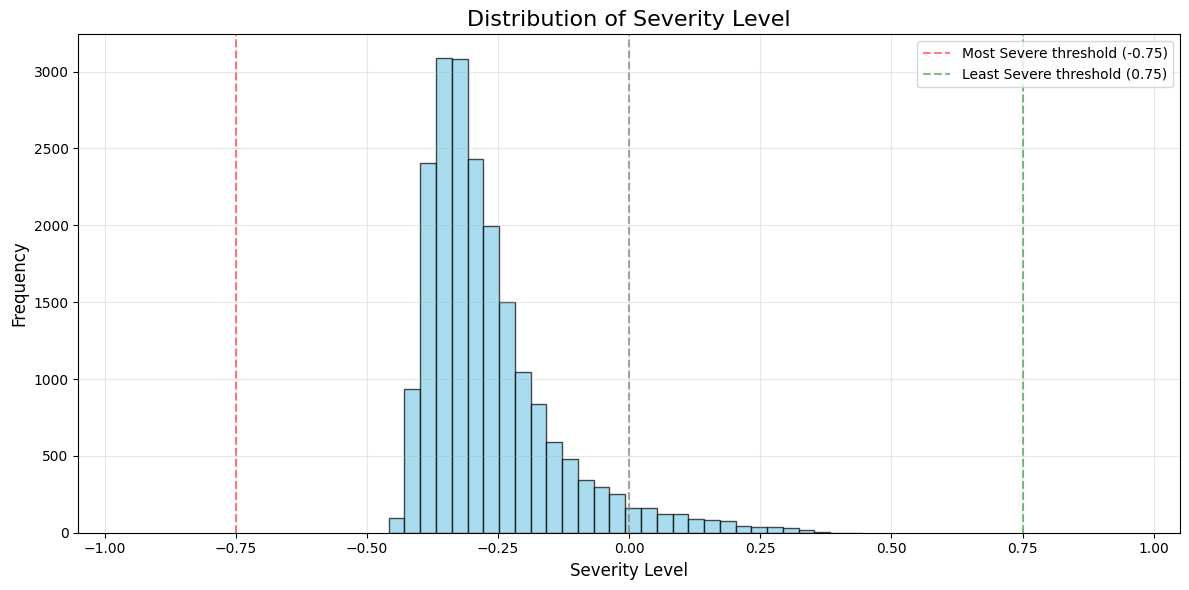

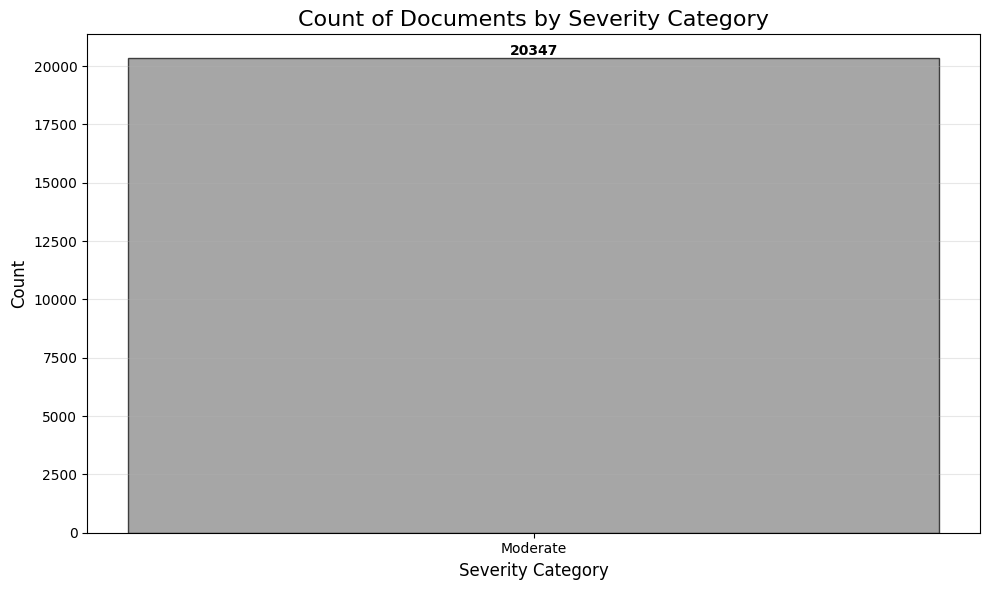

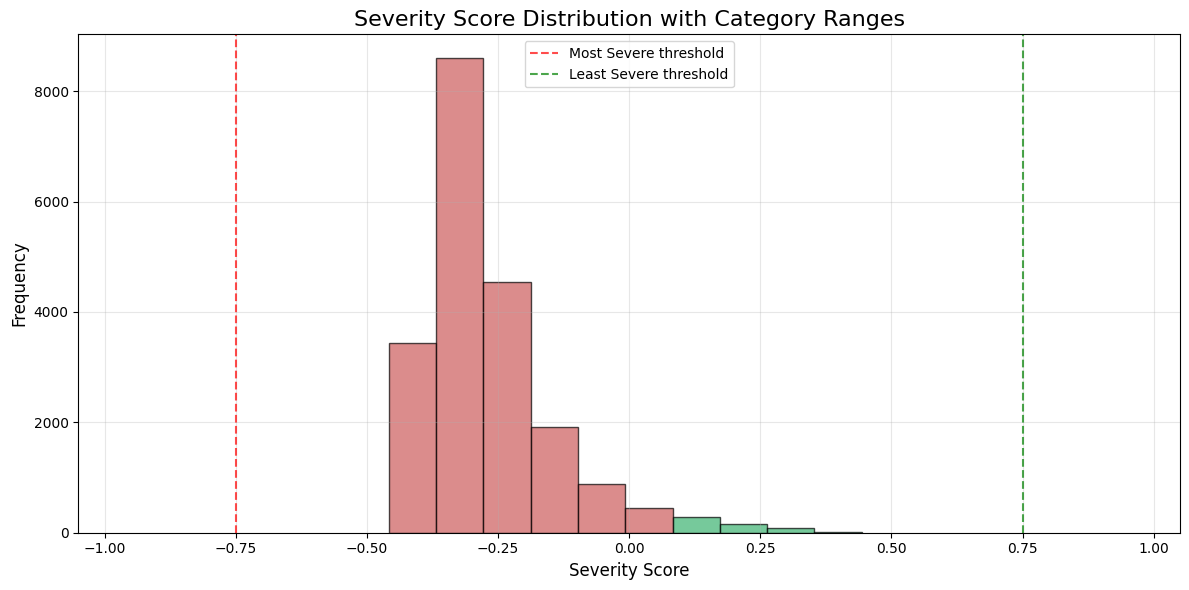

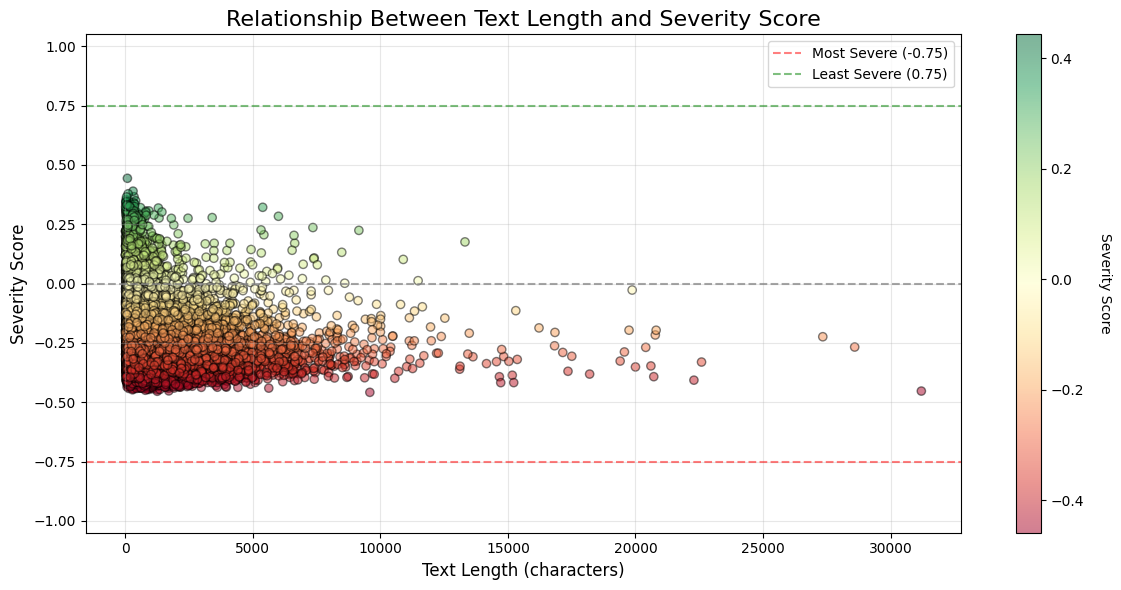

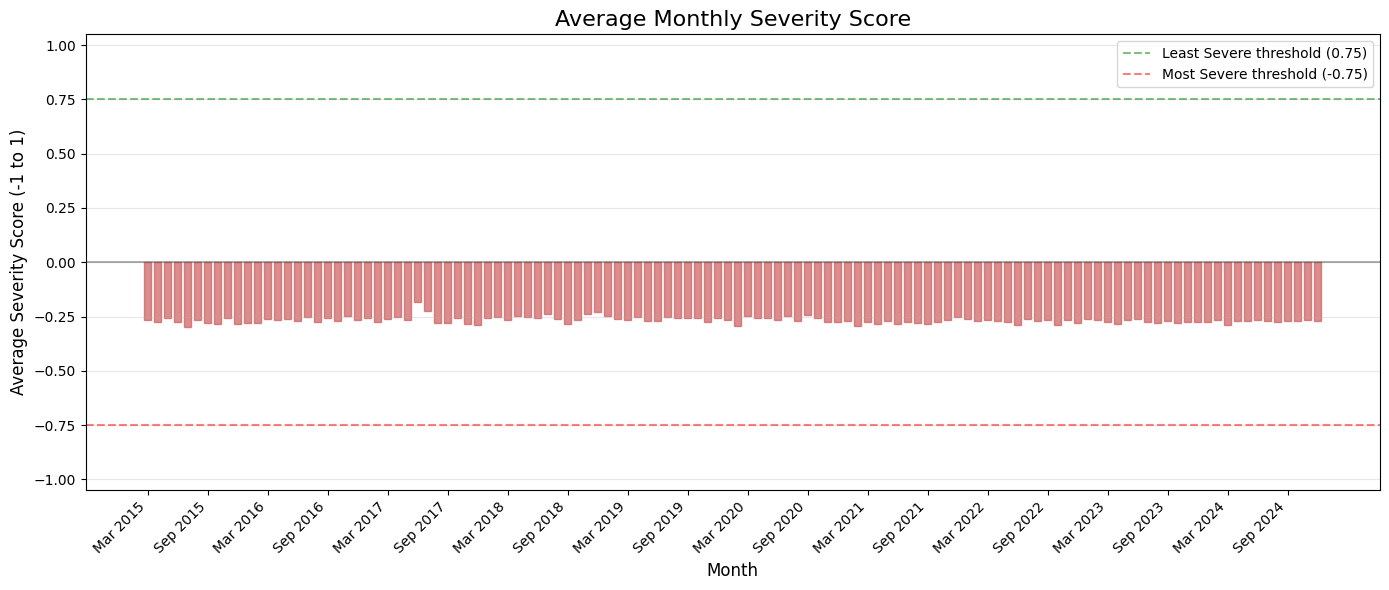

In [52]:
# First, create a categorized version of your dataframe
categorized_df = create_sentiment_categories(scored_df)

# Generate histogram of severity scores
fig1 = plot_sentiment_distribution(scored_df)
plt.show()

# Generate bar chart of severity categories
fig2 = plot_sentiment_barchart(categorized_df)
plt.show()

# Generate histogram with colored regions for severity scores
fig3 = plot_score_ranges(categorized_df)
plt.show()

# If you have a text column, visualize relationship between text length and severity
if 'Complaint' in scored_df.columns:
    fig4 = plot_text_length_vs_sentiment(categorized_df, 'Complaint')
    plt.show()

# If you have a date column, visualize monthly severity trends
if 'Date' in scored_df.columns:
    fig5 = plot_monthly_sentiment(scored_df, 'Date')
    plt.show()